In this notebook, we examine the flow of a slightly more sophisticated compartmental model known as Susceptible-Exposed-Infected-Recovered (SEIR). This model is the next step in scaling up to more complicated population modeling, and provides an intuitive extension to SIR. Additionally, we also introduce here the u parameter, and how we can use it to observe how policy can impact the growth or decline of infection rate. 

## SEIR Model

### Model Dynamics 

We now define the equations as follows:

$$
s(t) + e(t) + i(t) + r(t) = 1 \\
\frac{dS}{dt} = -\beta S(t) i(t) \\
\frac{dE}{dt} = \beta S(t) i(t) - \lambda_1 E(t) \\
\frac{dI}{dt} = \lambda_1 E(t) - \lambda_2 i(t)  \\
\frac{dR}{dt} = \lambda_2 i(t)
$$

The intuition behind this new compartment is that there is a significant incubation period for infections, where indivuals are not yet infections. It's using this exposed period that population cannot spread the disease, themselves, but will soon start showing symptoms and therefore move to the $I$ compartment. 


Using our Pyro chops, we could build this model from scratch in a manner very similar to the way we did for SIR, but instead we take advantage of Pyro's compartmental modules and can start from that. 

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [10]:
from argparse import Namespace
args = Namespace(population=3000, 
                 incubation_time = 7.,
                 min_observations=1000,
                 max_observations=2500,
                 duration=180,
                 forecast=25, 
                 basic_reproduction_number=4.5,  # what our epidemic's R0 is.
                 recovery_time=24.0,  #recovery time. These values are 
                 response_rate=0.85,  # this is the probability of observed infections (noisy)
                 enum=True, 
                 sequential=True, 
                 num_samples=1000, 
                 warmup_steps=100, 
                 max_tree_depth=5, 
                 rng_seed=0, 
                 double=True, 
                 jit=True, 
                 cuda=False, 
                 verbose=True, 
                 plot=True,
                 policy_intervention=0)

In [11]:
class SimpleSEIRModel(CompartmentalModel):
    """
    Susceptible-Exposed-Infected-Recovered model.

    This is a stochastic discrete-time discrete-state model with four
    compartments: "S" for susceptible, "E" for exposed, "I" for infected,
    and "R" for recovered individuals (the recovered individuals are
    implicit: ``R = population - S - E - I``) with transitions
    ``S -> E -> I -> R``.

    :param int population: Total ``population = S + E + I + R``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
        
    NK: In our implementation we keep all the same, but now introduce u, 
    as previously discussed, as a means to demonstrate intervention efficacy. 
    """

    def __init__(self, population, incubation_time, recovery_time, data):
        compartments = ("S", "E", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)

        assert isinstance(incubation_time, float)
        assert incubation_time > 1
        self.incubation_time = incubation_time

        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time

        self.data = data

    def global_model(self):
        tau_e = self.incubation_time
        tau_i = self.recovery_time
        
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(10, 10)) # noisy observations. Whatever the true number of infections is, will be something 
                                                    # scaled by this random variable rho. 
        
        # Policy intervention parameter. Used to reduce flow S2E
        u = pyro.sample("u", dist.Uniform(0, 0.85)) # it's unrealistic to get a u to high, so we set it as a value between 0 and 0.85.  

        return R0, tau_e, tau_i, rho,u

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, rho, u  = params

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate= (1 - u) * R0 / tau_i,   # As in SIR, scaled by 1-u for intervention
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_e))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau_i))

        # Update compartments with flows.
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.data[t] if t_is_observed else None)



With our class defined, the first thing we should do is test whether or not it works effectively by generating a sample trajectory. The way we do this is by initializing some values about the epidemic, and simulate.

In [12]:

empty_data = [None] * args.duration # fill this array if you wish to condition on real world data. 
model = SimpleSEIRModel(args.population, args.incubation_time,args.recovery_time, empty_data)


# We'll repeatedly generate data until a desired number of infections is found.
for attempt in range(100):
    synth_data = model.generate({"R0": args.basic_reproduction_number,"u":args.policy_intervention}) # starting values for R0 and u. 
    total_infections = synth_data["S2E"].sum().item()
    #    print('total_infections:',total_infections)
    if args.min_observations <= total_infections <= args.max_observations:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


Simulated 1407.0 infections after 19 attempts


## Visualizing the Synthetic Data

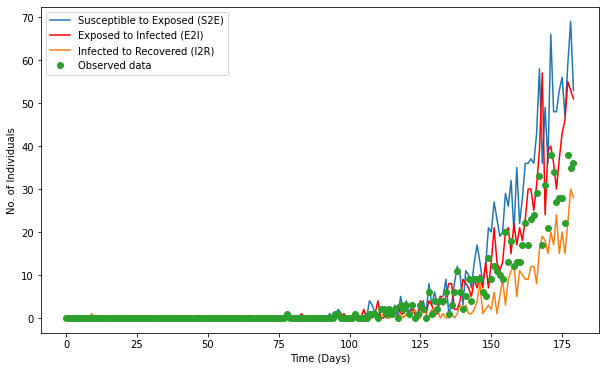

In [13]:
figure = plt.figure(figsize=(10, 6))
plt.plot(synth_data['S2E'],label='Susceptible to Exposed (S2E)')
plt.plot(synth_data['E2I'],'r',label='Exposed to Infected (E2I)')
plt.plot(synth_data['I2R'],label='Infected to Recovered (I2R)')
plt.plot(synth_data['obs'],'o',label='Observed data')
plt.xlabel('Time (Days)')
plt.ylabel('No. of Individuals')
plt.legend()

As it was the case for SIR, it would be much easier to visualize this if we could model the individual compartments over time using the sum total of individuals belonging to each compartment at each time-step and interpolating between them for ease of visualization. 



## Impact of Varying Policy Interventions (u) on SEIR Model

In this section, we re-introduce policy interventions which represent the government implementing various policies to limit the spread of COVID-19. We will consider a simple case where we want to know what is the minimally invasive policy corresponding to the value $u_{min}$ that can be implemented to limit the spread of COVID right at the outset of the disease spread. While we can easily implement more complex models for policy interventions, we will leave that as future work and point the readers to the paper ["Planning as Inference for Epidemiological Models"](https://arxiv.org/abs/2003.13221) that served as an inspiration for this line of work. 

We should mention that we are actively working on more complex modeling of interventions such as "What is the minimally invasive policy *at each time step* that can limit the spread of the infections"?

In [18]:
import numpy as np
np.random.seed(1234)

def intervention_gridsearch(args, data=None):
    fig, ax = plt.subplots(3,3, figsize=(15,15))
    dummyu = np.arange(0, 0.7, 0.07)
    count = 0
    for ii in range(3):   # since i is used for the compartmental model
        for j in range(3):
            args.policy_intervention = dummyu[count]
            if args.policy_intervention > 0.8:
                args.min_observations = 0

            torch.manual_seed(1234)
            pyro.set_rng_seed(1234)
            while True:
                data = model.generate({"R0": args.basic_reproduction_number,"u":args.policy_intervention}) # starting values for R0 and u. 

                total_infections = data["S2E"].sum().item()
                #    print('total_infections:',total_infections)
                if 500 <= total_infections <= args.max_observations:
                    break

            _S = []
            _E = []
            _I = []
            _R = []

            s = args.population - 1
            e = 0
            i = 1
            r = 0

            for t in range(args.duration):
                s -= data['S2E'][t].item()
                e += data['S2E'][t].item()
                e -= data['E2I'][t].item()
                i += data['E2I'][t].item()
                i -= data['I2R'][t].item()
                r += data['I2R'][t].item()
                _S.append(s)
                _E.append(e)
                _I.append(i)
                _R.append(r)

            _S = torch.tensor(_S)/args.population
            _E = torch.tensor(_E)/args.population
            _I = torch.tensor(_I)/args.population
            _R = torch.tensor(_R)/args.population
            
            
            x_vals = np.arange(0, len(_S), 1)  # length of all arrays is the same as duration
            # plot the threshold
            ax[ii, j].plot([0.1]*len(_S), label='threshold', color='black', linestyle='dashed')
            #ax[ii, j].set_yscale('log')        

            ax[ii, j].plot(_S, label='S', color='gold', alpha=0.9)
            ax[ii, j].fill_between(x_vals, _S, color='gold', alpha=0.15)

            ax[ii, j].plot(_R, label='R', color='palegreen', alpha=0.9)
            ax[ii, j].fill_between(x_vals, _R, color='palegreen', alpha=0.45)

            # plot the infections last so that it's on top
            ax[ii, j].plot(_E, label='E', color='yellow', alpha=0.9)
            ax[ii, j].fill_between(x_vals, _E, color='yellow', alpha=0.60)

            
            # plot the infections last so that it's on top
            ax[ii, j].plot(_I, label='I', color='lightcoral', alpha=0.9)
            ax[ii, j].fill_between(x_vals, _I, color='lightcoral', alpha=0.75)

            
            ax[ii, j].legend(loc="upper right")
            ax[ii, j].set_title("u = {:.2f}".format(args.policy_intervention))
            count += 1
    #plt.savefig('/home/code-base/covid/intervention_grid.png', dpi=150, bbox_width='tight')

    # reset policy intervention
    args.policy_intervention = 0 

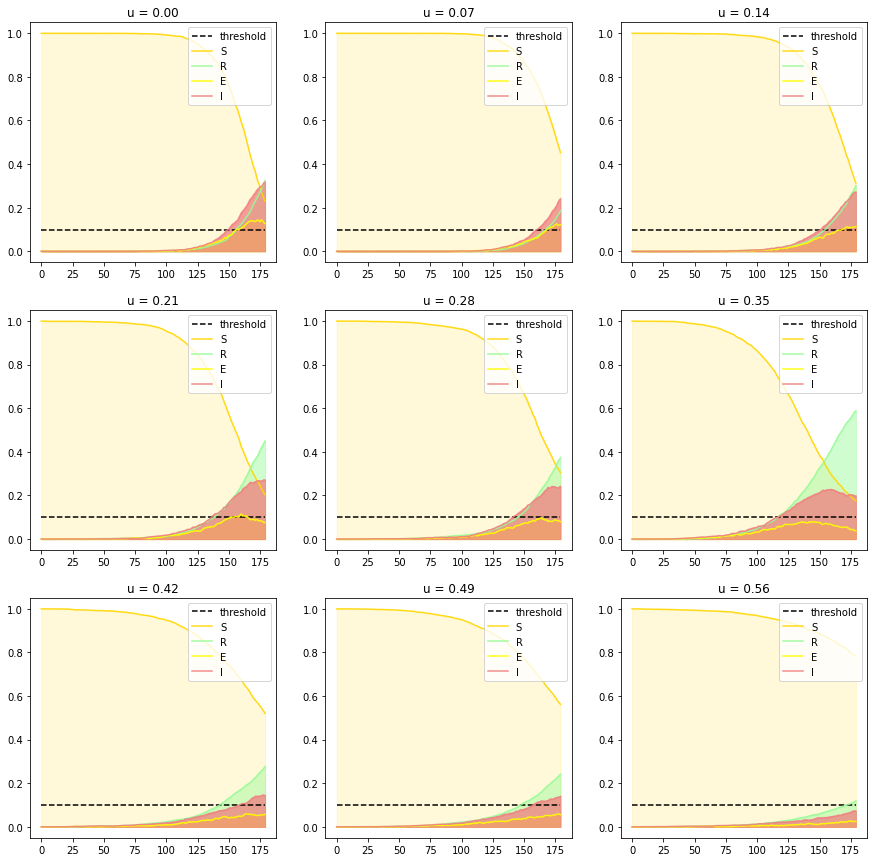

In [19]:
intervention_gridsearch(args)

In [9]:
def apply_intervention(args, rate_s, params=None):
    """
    Checks and applies a policy intervention to limit the rate of spread of infection
    TODO: This could search over a grid of u values and return the minimum intervention [Future Work]
    """
    # run a simulation of the current model at each time step to obtain minimally invasive
    # estimated values for u
#     set_trace()
#     simulation_args = Namespace(population=args.population, 
#                  min_observations=0,                # no min infections
#                  max_observations=args.population,  # no max infections
#                  duration=180,
#                  forecast=25, 
#                  basic_reproduction_number=pyro.param("R0").item(),  # what our epidemic's R0 is.
#                  recovery_time=args.recovery_time,
#                  response_rate=pyro.param("rho").item(),             # this is the probability of observed infections (noisy)
#                  policy_intervention=0)
    
    if args.policy_intervention > 0:
        u = pyro.deterministic("u", torch.tensor([args.policy_intervention]))
    else:
        u = pyro.deterministic("u", torch.tensor([0.]))
    rate_s = (1. - u) * rate_s
    # for future use, return the final u determined by executing multiple trajectories and 
    # finding the minimally invasive u for a satisfactory trajectory of disease evolution
    return rate_s, u



In [ ]:
apply_intervention(args,rate_s=2)

As you can see, the greater the value of u, the flatter the curve!


In our next experiments, we will perform inference using SEIR and some synthetic data, and see what sort of posterior estimates it acquires.

For consistency, let's use the same data from before.

In [ ]:

empty_data = [None] * args.duration # fill this array if you wish to condition on real world data. 

model = SimpleSEIRModel(args.population, args.incubation_time,args.recovery_time, empty_data)


# We'll repeatedly generate data until a desired number of infections is found.
for attempt in range(100):
    synth_data = model.generate({"R0": args.basic_reproduction_number,"u":args.policy_intervention}) # starting values for R0 and u. 
    total_infections = synth_data["S2E"].sum().item()
    print('total_infections:',total_infections)
    if args.min_observations <= total_infections <= args.max_observations:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


In [ ]:


obs = synth_data["obs"]
model = SimpleSEIRModel(args.population, args.incubation_time, args.recovery_time, obs) 



In [ ]:
%%time
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 1000,
                      jit_compile=True,)

In [ ]:
mcmc.summary()

In [ ]:
mcmc.diagnostics()

In [ ]:
%%time
samples = model.predict()

In [ ]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

In [ ]:
names = ["R0", "rho","u"]
fig, axes = plt.subplots(3, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()


The posterior estimate for u is poor, but this is acceptable when you consider how the value for R0 is also under-estimated. Based on the equations, this makes sense, because we expect u to create an effectively smaller value for R0, and this is what we recover. 

Furthermore, we can forecast using this model.

In [ ]:
%time
samples = model.predict(forecast=30)

def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2E = samples["S2E"]
    median = S2E.median(dim=0).values
    p05 = S2E.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2E.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2E"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)